### 1. M-Map 생성

In [ ]:
import math
import pandas as pd

csv_df = pd.read_csv("data/position_data (10).csv")
mmap_df = pd.DataFrame()

mmap_df['X'] = csv_df['X'] + 8
mmap_df['Y'] = csv_df['Y'] + 66-14
mmap_df['mag'] = csv_df.apply(lambda x: math.sqrt(x['UncalMagX']*x['UncalMagX'] + x['UncalMagY']*x['UncalMagY'] + x['UncalMagZ']*x['UncalMagZ']), axis=1 )

mmap_df.loc[335:, 'X'] = mmap_df.loc[335:, 'X'] - 5
mmap_df.loc[425:, 'X'] = mmap_df.loc[425:, 'X'] - 5
mmap_df.loc[425:, 'Y'] = mmap_df.loc[425:, 'Y'] + 3
mmap_df

,X,Y,mag
0,8,52,10.607620
1,9,52,12.941236
2,10,52,16.139108
3,11,52,12.410286
4,12,52,15.870652
...,...,...,...
607,11,48,40.031737
608,11,49,33.741396
609,11,50,21.573484
610,11,51,22.700149


### 2. M-Map 시각화

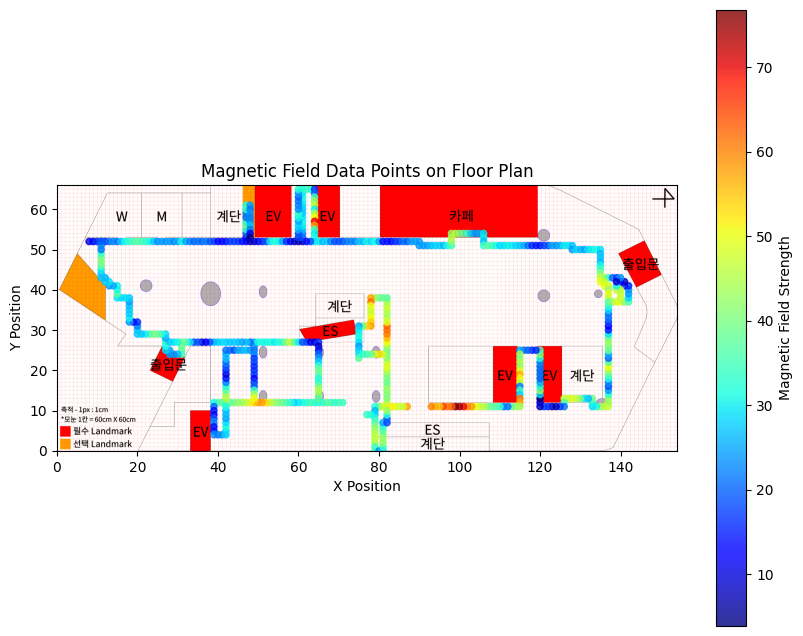

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize

# 1. 평면도 이미지 불러오기
floor_plan_path = 'floor_plan/KakaoTalk_20241124_152724186_02.png'  # 평면도 이미지 파일 경로
floor_plan = cv2.imread(floor_plan_path)
floor_plan = cv2.cvtColor(floor_plan, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 포맷이므로 RGB로 변환

# 2. 데이터 분리
x = mmap_df['X'].to_numpy()
y = mmap_df['Y'].to_numpy()
mag = mmap_df['mag'].to_numpy()

# 3. 컬러 매핑 설정
norm = Normalize(vmin=np.min(mag), vmax=np.max(mag))  # 값의 범위 정규화
cmap = colormaps.get_cmap('jet')  # 컬러맵 설정
colors = cmap(norm(mag))  # 값을 컬러맵으로 변환

# 4. 평면도 위에 점만 표시
plt.figure(figsize=(10, 8))

# 평면도 이미지를 뒤집히지 않게 하기 위해 origin='upper'로 설정
plt.imshow(floor_plan, extent=(0, 154, 0, 66), origin='upper') # extent=(x_min, x_max, y_min, y_max)

# 데이터 포인트에 색깔과 크기 적용
scatter = plt.scatter(x, y, c=mag, s=20, cmap=cmap, norm=norm, alpha=0.8)  # scatter의 cmap과 norm 설정

# 컬러바 추가
plt.colorbar(scatter, label='Magnetic Field Strength')  # scatter를 기반으로 컬러바 생성

plt.title('Magnetic Field Data Points on Floor Plan')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()


### 3. 보간된 M-Map

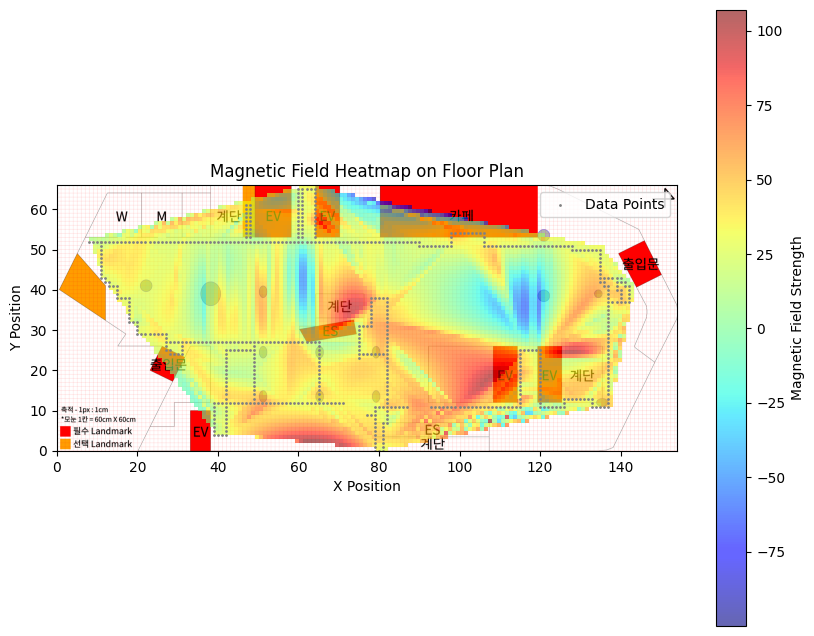

In [8]:
from scipy.interpolate import griddata

x = mmap_df['X'].to_numpy()
y = mmap_df['Y'].to_numpy()
mag = mmap_df['mag'].to_numpy()

# Grid 생성 (Heatmap 인터폴레이션)
grid_x, grid_y = np.mgrid[0:154:1, 0:66:1]  # 원하는 x, y 범위로 Grid 생성
grid_z = griddata((x, y), mag, (grid_x, grid_y), method='cubic')

mmap_grid_df = pd.DataFrame({'X': grid_x.flatten(), 'Y': grid_y.flatten(), 'mag': grid_z.flatten()})

# Heatmap 생성
plt.figure(figsize=(10, 8))
plt.imshow(floor_plan, extent=(0, 154, 0, 66), origin='upper') # 평면도 표시
plt.imshow(grid_z.T, extent=(0, 154, 0, 66), cmap='jet', alpha=0.6, origin='lower') # Heatmap 오버레이 (alpha로 투명도 조절)

# 컬러바 추가
plt.colorbar(label='Magnetic Field Strength')
plt.scatter(x, y, c='white', edgecolors='grey', s=1, label='Data Points')  # 데이터 포인트 표시
plt.legend()
plt.title('Magnetic Field Heatmap on Floor Plan')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()